In [1]:
import pandas as pd 
import numpy as np
from utils_ import utilss
from utils_ import ImpliedVar
from models.Core import Core
import matplotlib.pyplot as plt 
import warnings 
from utils_ import IVTermStructure
from utils_ import IVStructureAnalysis
from utils_ import RV
import tqdm
from models import FiniteDifference
warnings.filterwarnings('ignore')
from transactions import transactions
from portfolio import portfolio


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### **1. Recalculate the Greeks**
- **Objective:** Gain insights into options price sensitivities.
- **Action Steps:**
  - Utilize models like Black-Scholes to compute Delta, Gamma, Theta, Vega, and Rho.
  - Analyze these Greeks for all options under consideration.

#### **2. Analyze Term Structure**
- **Objective:** Identify trading opportunities from IV variations over time.
- **Action Steps:**
  - Examine IV across different expiration dates for each contract.
  - Determine market conditions (contango or backwardation).

#### **3. Strategy Formulation Based on IV**
- **Objective:** Develop a buying or selling strategy predicated on IV expectations.
- **Action Steps:**
  - If in contango, consider selling longer-term options while buying shorter-term ones.
  - In case of backwardation, buy longer-term options and sell shorter-term ones.

#### **4. Generate Buy and Sell Orders**
- **Objective:** Translate the IV-based strategy into actionable orders.
- **Action Steps:**
  - Identify specific contracts to buy or sell based on the strategy.
  - Determine the size and timing of each order.

#### **5. Execute Orders and Log Transactions**
- **Objective:** Implement the trading strategy in the market.
- **Action Steps:**
  - Use a brokerage platform to execute buy and sell orders.
  - Maintain a detailed log of all transactions for future analysis.

#### **6. Track Open Positions with FIFO**
- **Objective:** Manage open positions and ensure accurate P&L calculations.
- **Action Steps:**
  - Implement FIFO (First In, First Out) logic to track sell orders.
  - Update open positions based on executed transactions.

#### **7. Calculate Realized and Unrealized PnL**
- **Objective:** Assess the financial performance of the trading strategy.
- **Action Steps:**
  - Determine realized PnL by comparing the execution prices of closed positions.
  - Calculate unrealized PnL based on current market prices of open positions.


# Upload, clean and process the Data


In [10]:
shifted_iv=realized_vol_df.groupby(['Option_Contract_ID','QUOTE_date'])['C_IV'].median().shift(1).reset_index().dropna()

In [11]:
rv=realized_vol_df.groupby(['Option_Contract_ID','QUOTE_date'])['rolling_yearly_vol'].mean().reset_index()
rv_iv_minus_1 = shifted_iv.merge(rv, on = ['Option_Contract_ID', 'QUOTE_date'], how='left')
rv_iv_minus_1['RV_IV_MINUS_ONE']  = rv_iv_minus_1['rolling_yearly_vol'] - rv_iv_minus_1['C_IV']

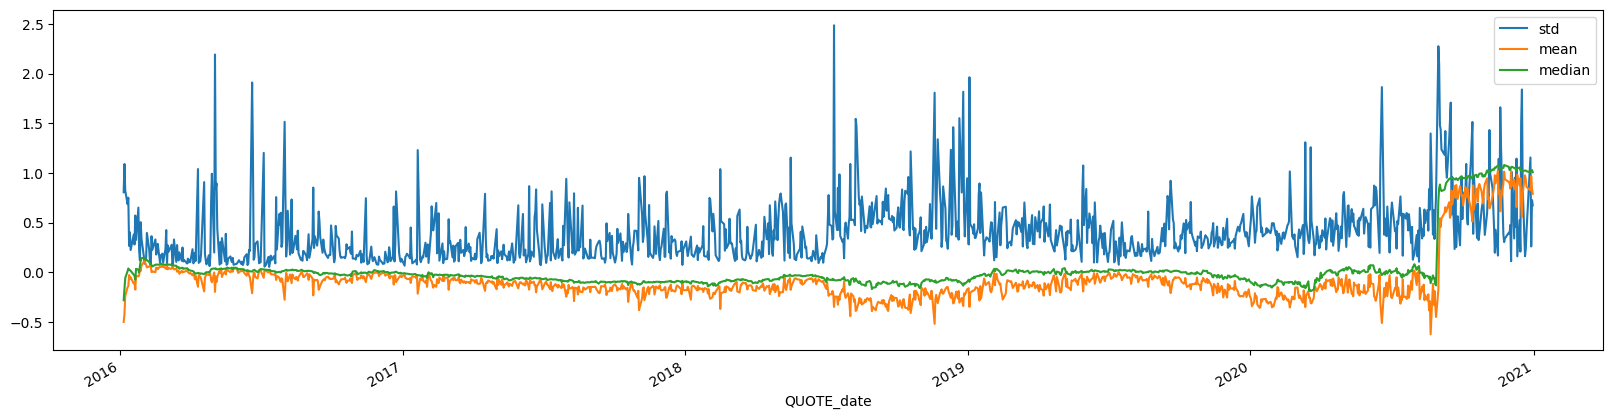

In [13]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
rv_iv_minus_1.groupby('QUOTE_date')['RV_IV_MINUS_ONE'].std().plot(label='std')
rv_iv_minus_1.groupby('QUOTE_date')['RV_IV_MINUS_ONE'].mean().plot(label='mean')
rv_iv_minus_1.groupby('QUOTE_date')['RV_IV_MINUS_ONE'].median().plot(label='median')
plt.legend()

In [2]:
import pandas as pd 
import numpy as np
from utils_ import utilss
from utils_ import ImpliedVar
from models.Core import Core
import matplotlib.pyplot as plt 
import warnings 
from utils_ import IVTermStructure
from utils_ import IVStructureAnalysis
from utils_ import RV
import tqdm
from models import FiniteDifference
warnings.filterwarnings('ignore')
from transactions import transactions
from portfolio import portfolio


def from_df__to_tensor_():
    dfx = utilss.process_and_merge_data(['data/aapl_2016_2020.csv'], ['TB3MS'], start_date='2016-01-01', end_date='2023-04-30')
    dfx['C_VOLUME'] =  dfx['C_VOLUME'].astype('float')
    dfx['P_VOLUME'] =  dfx['P_VOLUME'].astype('float')
    dfx=dfx.dropna()
    df_sub=dfx.iloc[:10000,  :]
    dfx=df_sub

    opml_instance = Core(dfx)
    df=opml_instance.add_greeks_to_df()
    df=opml_instance.add_bs_call_price()
    df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'], format='%Y-%m-%d')
    df['Option_Contract_ID'] = ("OP" + df['STRIKE'].astype(str) + '-'+df['EXPIRE_DATE'].dt.day.astype(str).str.zfill(2) +'-'+df['EXPIRE_DATE'].dt.month.astype(str).str.zfill(2) +'-'+  df['EXPIRE_DATE'].dt.year.astype(str))

    iv_term_structure = IVTermStructure.IVTermStructure(df)
    term_structures_df = iv_term_structure.get_iv_term_structure_modified()
    processed_df = iv_term_structure.prepare_training_df()
    tensors= iv_term_structure.generate_matrices(term_structures_df)
    
    return term_structures_df, tensors

    


In [3]:
term_structures_df,tensors=from_df__to_tensor_()

Calculating IV Term Structures: 100%|███████████████████████████████████████████| 2538/2538 [00:00<00:00, 16950.49it/s]


NameError: name 'option_id' is not defined

In [10]:
tensors

[array([[ 5.9379e-01,  4.8428e-01,  4.2323e-01,  3.6712e-01,  3.3183e-01,
          3.1451e-01,  3.0630e-01,  3.0127e-01,  3.0499e-01,  2.9502e-01,
          3.2411e-01],
        [ 4.3620e-02,  5.1700e-02,  5.7820e-02,  7.5350e-02,  1.0421e-01,
          1.8404e-01,  2.0428e-01,  2.2509e-01,  2.8538e-01,  3.3159e-01,
          4.2012e-01],
        [ 1.4540e-02,  2.2040e-02,  2.8510e-02,  4.4710e-02,  6.9780e-02,
          1.4916e-01,  1.7567e-01,  2.0280e-01,  2.8450e-01,  3.5191e-01,
          5.2901e-01],
        [ 9.7500e-03,  1.0470e-02,  1.1050e-02,  1.2390e-02,  1.3940e-02,
          1.5100e-02,  1.4960e-02,  1.4730e-02,  1.3250e-02,  1.2650e-02,
          8.8000e-03],
        [ 1.0100e-03,  1.9200e-03,  3.1000e-03,  7.3600e-03,  1.5140e-02,
          5.3200e-02,  7.2290e-02,  9.2620e-02,  1.7286e-01,  2.6813e-01,
          5.6033e-01],
        [-4.1470e-02, -2.9400e-02, -2.3980e-02, -2.0640e-02, -1.8580e-02,
         -1.7820e-02, -1.7100e-02, -1.6680e-02, -1.5000e-02, -1.4570e-0

In [32]:
plt.plot(tensors[1][-1],tensors[1][1])
plt.plot(tensors[1][-1],tensors[1][2])
plt.plot(tensors[1][-1],tensors[1][3])
plt.plot(tensors[1][-1],tensors[1][4])
plt.plot(tensors[1][-1],tensors[1][5])


IndexError: index 1 is out of bounds for axis 0 with size 1

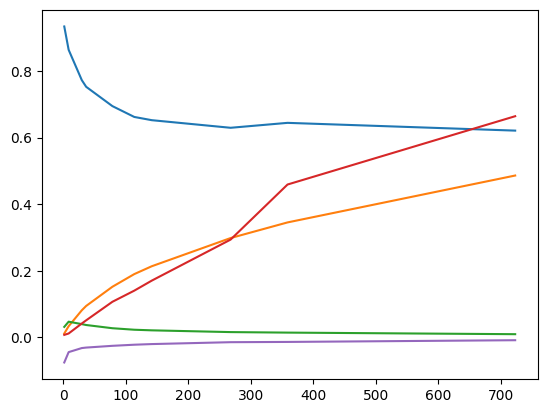

In [29]:
plt.plot(tensors[0][-1],tensors[0][1])
plt.plot(tensors[0][-1],tensors[0][2])
plt.plot(tensors[0][-1],tensors[0][3])
plt.plot(tensors[0][-1],tensors[0][4])
plt.plot(tensors[0][-1],tensors[0][5])


In [40]:
decision_df = analysis.analyze_structure(max_workers=4)

Analyzing IV Structures: 100%|██████████| 559/559 [00:08<00:00, 62.23it/s] 


In [41]:
decision_df

,DATE,DECISION,CONTRACT_ID,PRICE,QUANTITY,DTE,C_DELTA,C_GAMMA,C_VEGA,EXPIRE_DATE,UNDERLYING
0,2016-01-08,Buy,OP97.5-05-02-2016,4.01,1,28.00,0.49187,0.03709,0.10825,2016-02-05,96.96
1,2016-01-08,Buy,OP97.5-12-02-2016,4.25,1,35.00,0.49300,0.03486,0.12141,2016-02-12,96.96
2,2016-01-08,Buy,OP97.5-26-02-2016,4.65,1,49.00,0.49803,0.03189,0.14267,2016-02-26,96.96
3,2016-01-08,Buy,OP97.5-18-03-2016,5.30,1,69.96,0.50397,0.02821,0.16979,2016-03-18,96.96
4,2016-01-08,Buy,OP97.5-15-04-2016,6.06,1,97.96,0.51075,0.02485,0.20068,2016-04-15,96.96
...,...,...,...,...,...,...,...,...,...,...,...
2057,2016-02-23,Buy,OP105.0-17-06-2016,2.07,1,114.96,0.25889,0.02280,0.17222,2016-06-17,94.69
2058,2016-02-23,Buy,OP105.0-15-07-2016,2.62,1,142.96,0.28689,0.02151,0.20178,2016-07-15,94.69
2059,2016-02-23,Buy,OP105.0-21-10-2016,4.55,1,240.96,0.35052,0.01732,0.28396,2016-10-21,94.69
2060,2016-02-23,Buy,OP105.0-20-01-2017,5.99,1,332.00,0.39454,0.01570,0.34777,2017-01-20,94.69


In [42]:
transactions_ = transactions.Transactions()
transactions_.add_transactions(decision_df)
net_spent_by_date_df = transactions_.calculate_net_spent_by_date()


In [43]:
transactions_.calculate_net_spent_by_date()

,DATE,NET_SPENT
0,2016-01-04,267.15
1,2016-01-06,13.62
2,2016-01-08,387.87
3,2016-01-11,513.89
4,2016-01-12,756.35
5,2016-01-13,341.92
6,2016-01-14,269.50
7,2016-01-15,276.17
8,2016-01-19,287.26
9,2016-01-20,281.19


In [44]:
x=portfolio.Portfolio(df,transactions_.get_transaction_log())
b=x.calculate_fifo_pnl()


In [45]:
b

,QUOTE_DATE,REALIZED_PNL,UNREALIZED_PNL
0,2016-01-04,0.00,-4.31
1,2016-01-05,0.00,-42.70
2,2016-01-06,0.00,-80.66
3,2016-01-07,0.00,-107.02
4,2016-01-08,0.00,-275.47
5,2016-01-11,0.00,-301.54
6,2016-01-12,0.00,-245.70
7,2016-01-13,0.00,-580.96
8,2016-01-14,0.00,-242.91
9,2016-01-15,0.00,-843.12


In [133]:
b=b.set_index('QUOTE_DATE')
b.UNREALIZED_PNL.plot()
b.REALIZED_PNL.plot()
plt.legend()
plt.show()

NameError: name 'b' is not defined

# VIZ

C_RHO_BS    0.043258
C_RHO       0.039520
Name: 0.6, dtype: float64

<Figure size 1500x1000 with 0 Axes>

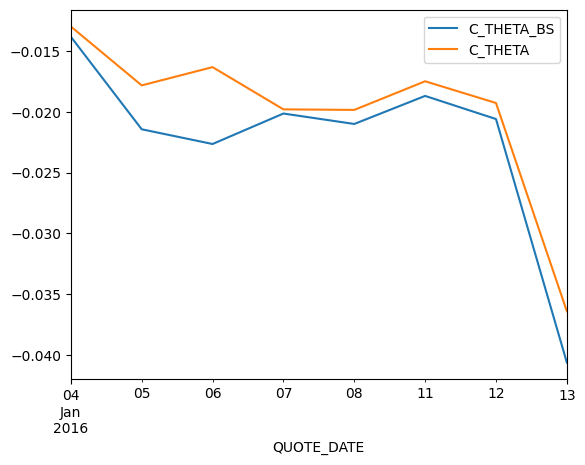

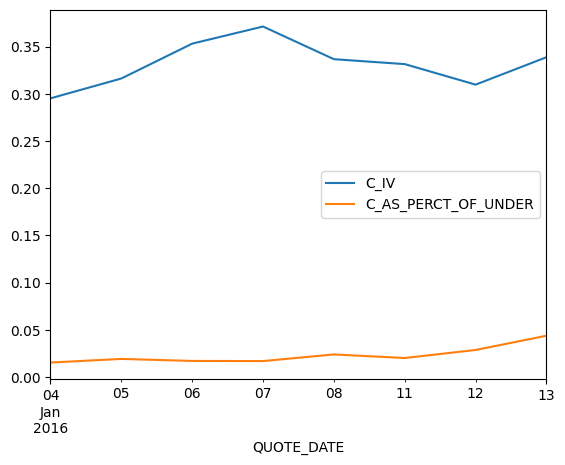

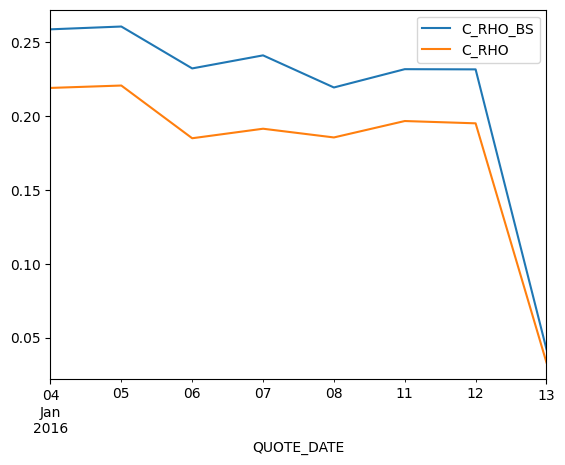

In [20]:
plt.figure(figsize=(15,10))
df.groupby(['QUOTE_DATE'])[['C_THETA_BS', 'C_THETA']].median().plot()
df.groupby(['QUOTE_DATE'])[['C_IV', 'C_AS_PERCT_OF_UNDER']].median().plot()
df.groupby(['QUOTE_DATE'])[['C_RHO_BS', 'C_RHO']].std().plot()
df[['C_RHO_BS', 'C_RHO']].quantile(0.6)

<Axes: xlabel='QUOTE_DATE'>

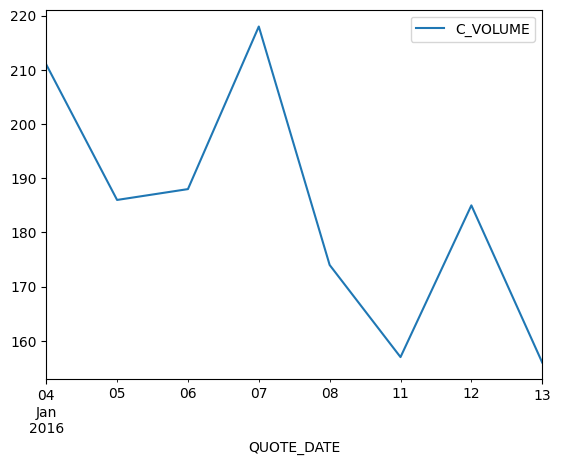

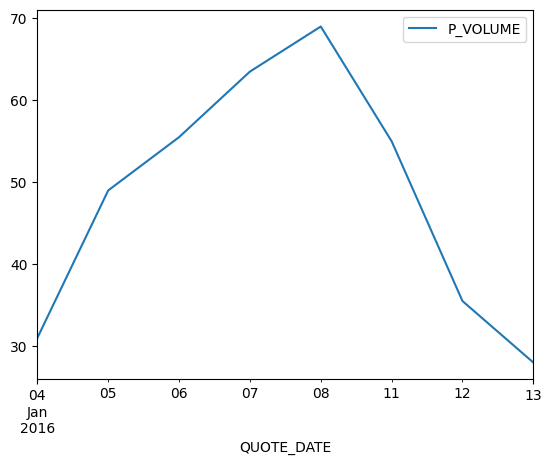

In [21]:
df.groupby(['QUOTE_DATE'])[['C_VOLUME']].median().plot()
df.groupby(['QUOTE_DATE'])[['P_VOLUME']].median().plot()


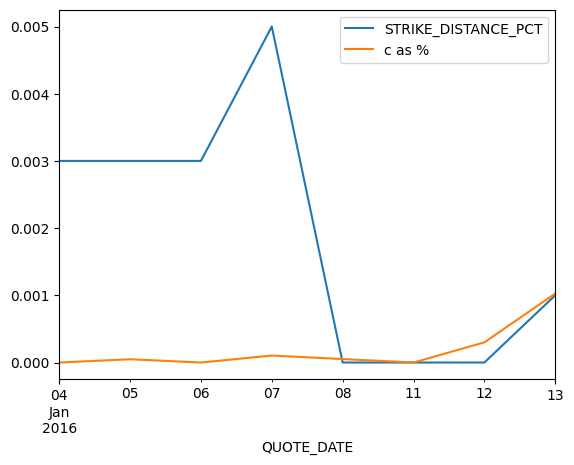

In [22]:
df.groupby(['QUOTE_DATE'])['STRIKE_DISTANCE_PCT'].min().plot()
df.groupby(['QUOTE_DATE'])['C_AS_PERCT_OF_UNDER'].min().plot(label='c as %')
plt.legend()

In [23]:
df[['C_RHO_BS', 'C_RHO']].quantile(0.998)

C_RHO_BS    1.067587
C_RHO       0.807747
Name: 0.998, dtype: float64

<Axes: xlabel='QUOTE_DATE'>

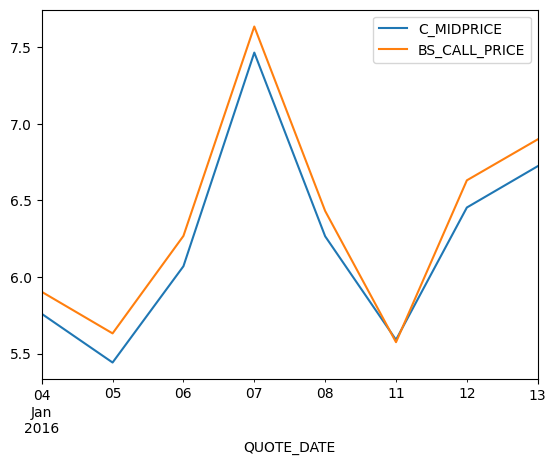

In [24]:
df.groupby(['QUOTE_DATE'])[['C_MIDPRICE', 'BS_CALL_PRICE']].mean().plot()


In [25]:
df[df['QUOTE_DATE']=='2017-09-15'].groupby(['STRIKE'])['EXPIRE_DATE'].mean()


Series([], Name: EXPIRE_DATE, dtype: datetime64[ns])

In [26]:
df.Option_Contract_ID.unique()

array(['OP60.0-20-01-2017', 'OP65.71-15-01-2016', 'OP70.0-20-01-2017',
       'OP70.0-19-01-2018', 'OP75.0-15-07-2016', 'OP78.57-15-01-2016',
       'OP80.0-15-01-2016', 'OP80.0-19-02-2016', 'OP80.0-18-03-2016',
       'OP80.0-15-04-2016', 'OP80.0-20-01-2017', 'OP80.0-19-01-2018',
       'OP85.0-20-01-2017', 'OP85.0-19-01-2018', 'OP90.0-15-04-2016',
       'OP90.0-20-01-2017', 'OP95.0-15-07-2016', 'OP95.0-20-01-2017',
       'OP95.0-19-01-2018', 'OP97.0-15-01-2016', 'OP97.14-15-01-2016',
       'OP97.5-18-03-2016', 'OP100.0-29-01-2016', 'OP100.0-15-04-2016',
       'OP100.0-19-01-2018', 'OP102.0-29-01-2016', 'OP102.0-05-02-2016',
       'OP103.0-29-01-2016', 'OP103.0-05-02-2016', 'OP104.0-22-01-2016',
       'OP104.0-29-01-2016', 'OP104.0-05-02-2016', 'OP104.0-12-02-2016',
       'OP105.0-05-02-2016', 'OP105.0-12-02-2016', 'OP105.0-17-06-2016',
       'OP105.0-15-07-2016', 'OP105.0-21-10-2016', 'OP105.0-19-01-2018',
       'OP106.0-22-01-2016', 'OP106.0-29-01-2016', 'OP106.0-05-02-2016

<Axes: xlabel='QUOTE_DATE'>

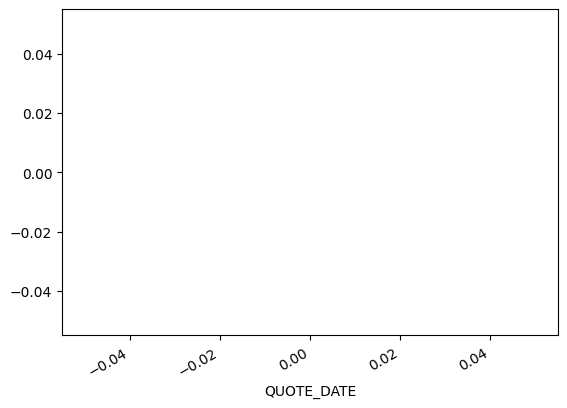

In [27]:
df[df['Option_Contract_ID']=='OP97.5-03-2016'].groupby('QUOTE_DATE')['UNDERLYING_LAST'].mean().plot()


<Axes: >

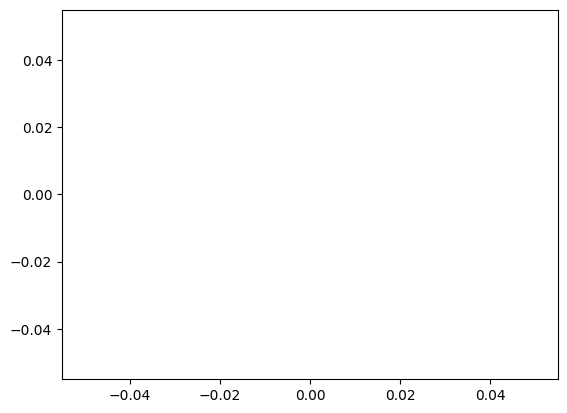

In [28]:
df[df['Option_Contract_ID']=='OP97.5-03-2016'].BS_CALL_PRICE.plot()
df[df['Option_Contract_ID']=='OP97.5-03-2016'].C_ASK.plot()
df[df['Option_Contract_ID']=='OP97.5-03-2016'].C_BID.plot()


In [29]:
df[df['Option_Contract_ID']=='OP120.0-01-2017']

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,r,d1,d2,C_DELTA_BS,C_GAMMA_BS,C_THETA_BS,C_VEGA_BS,C_RHO_BS,sigma,BS_CALL_PRICE


## Visualize the volatility surface  

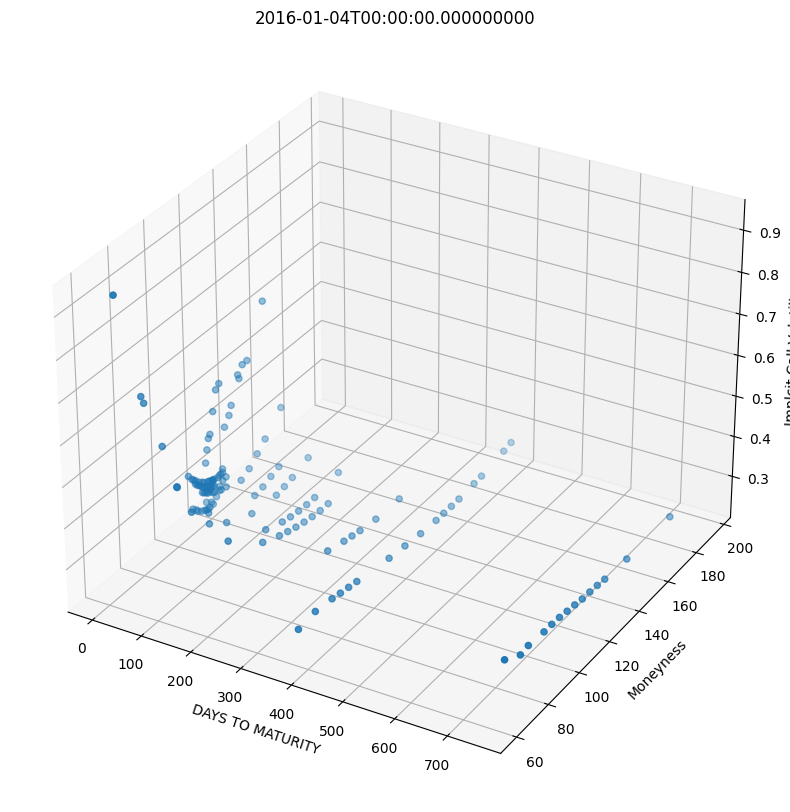

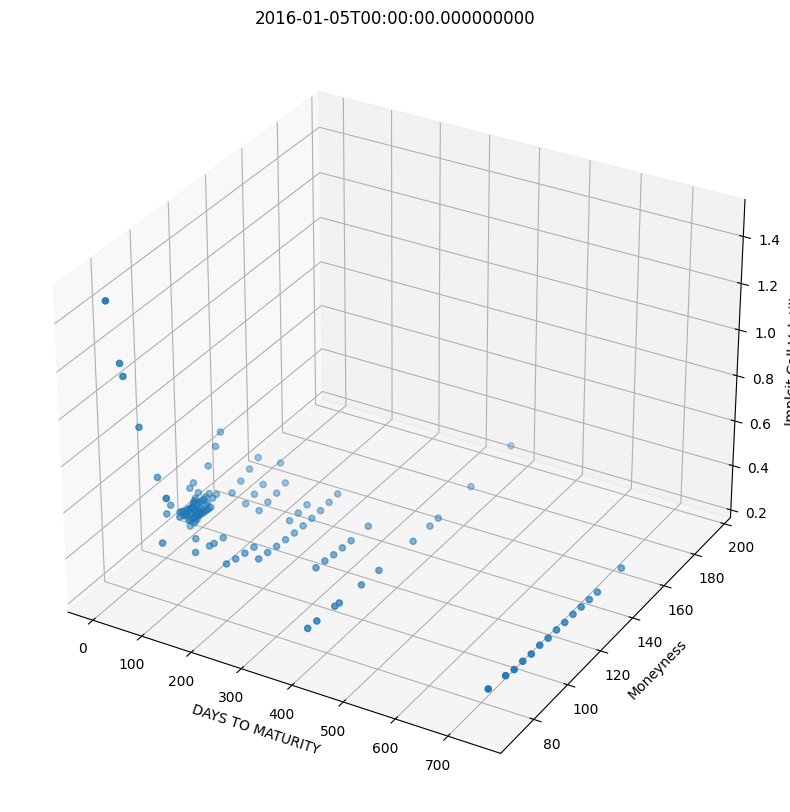

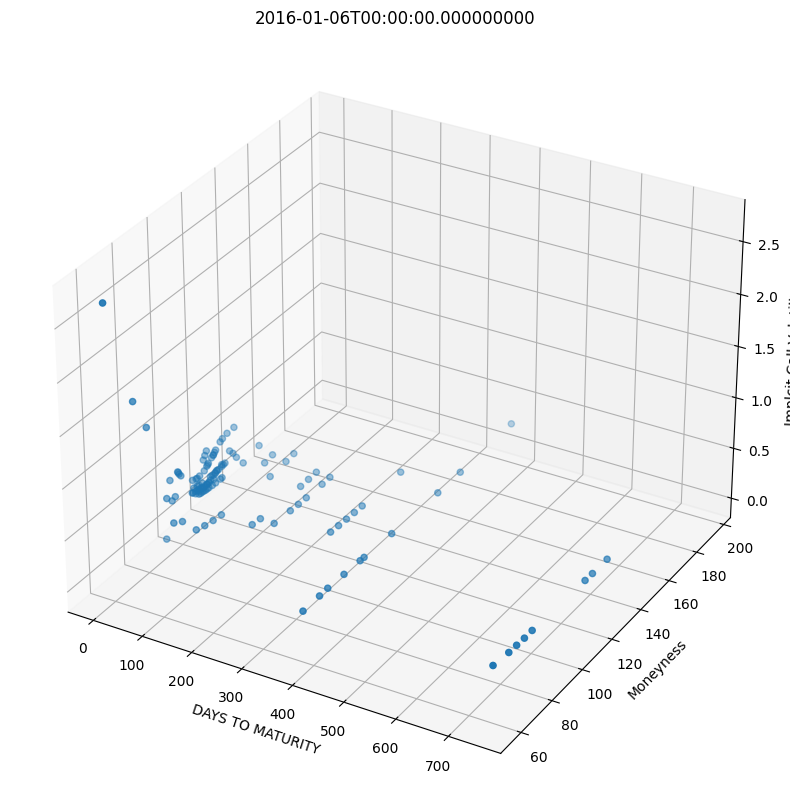

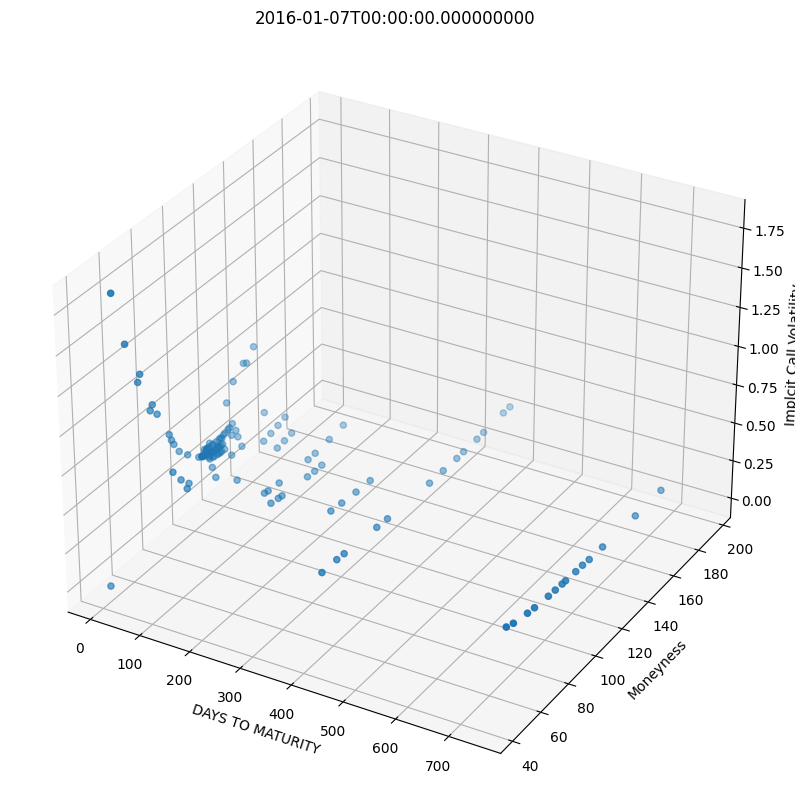

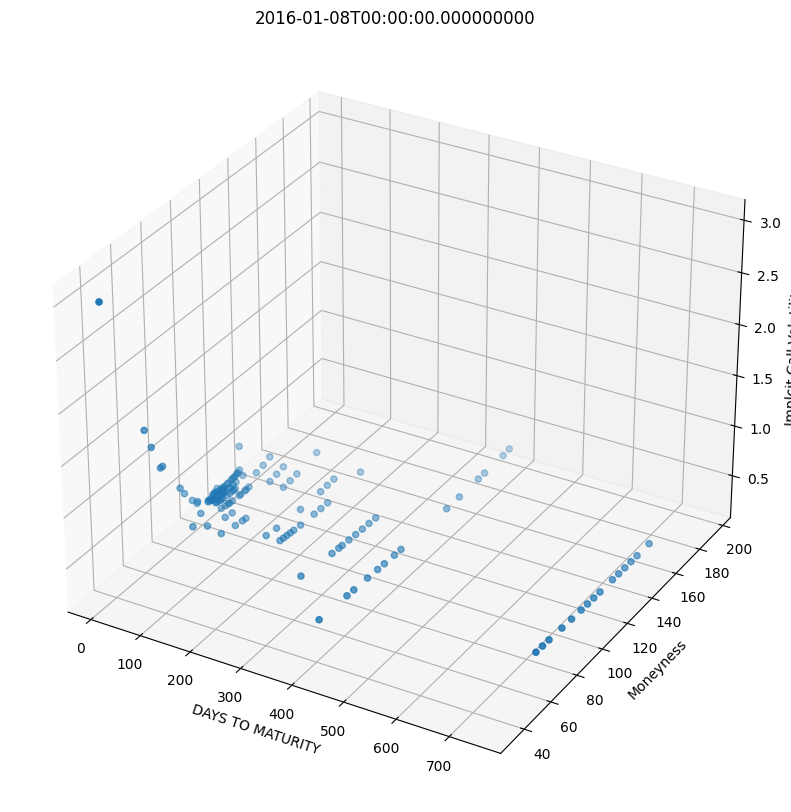

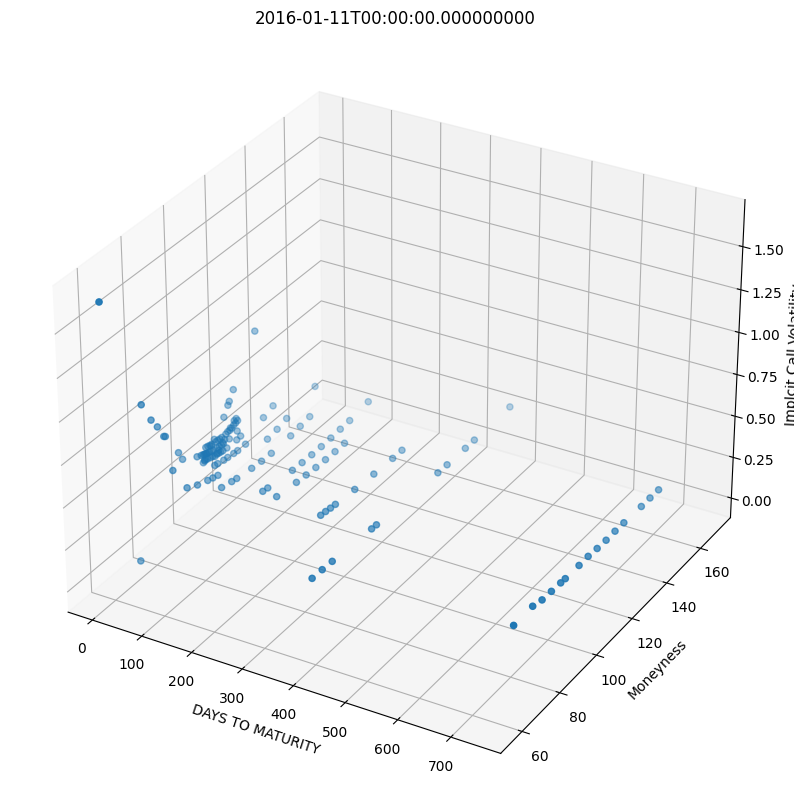

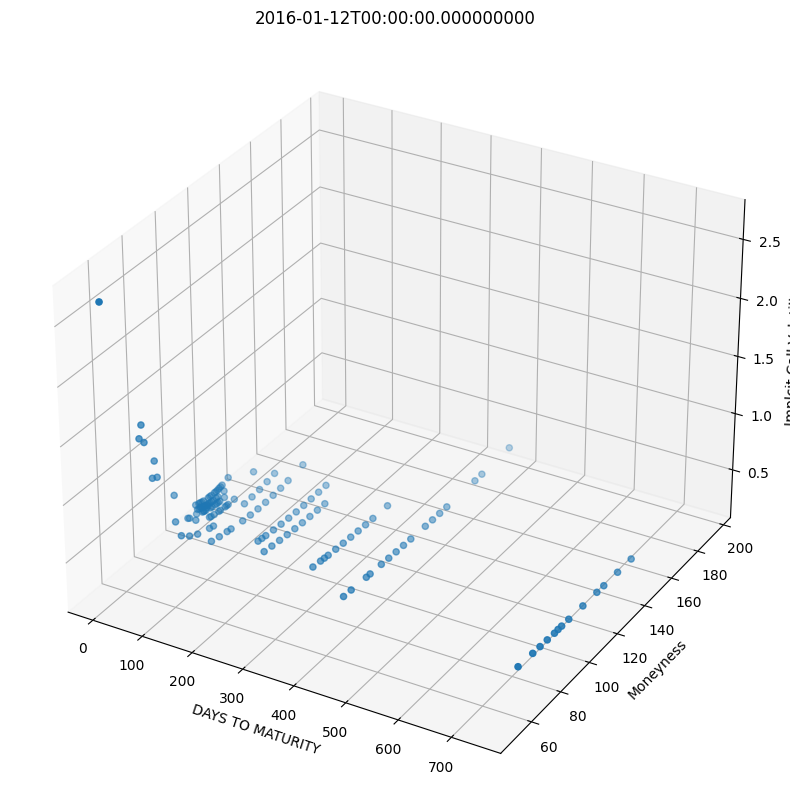

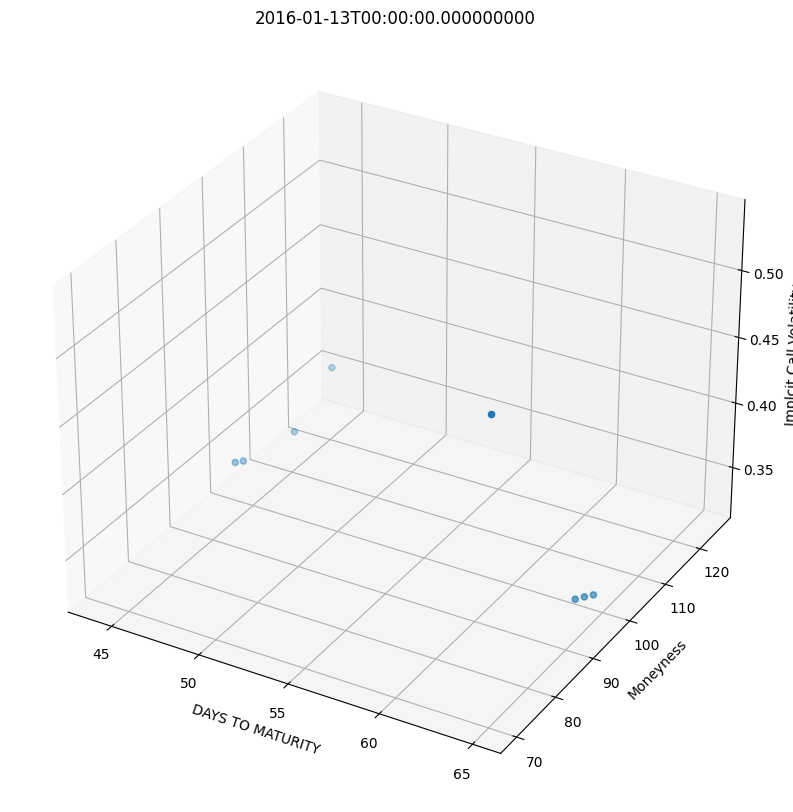

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a copy of the dataframe
copy_df = df.copy()

# Create empty lists to store data
dates = []
C_IV_values = []
strike_values = []
DTE_values = []

# Iterate over unique dates
for date in copy_df['QUOTE_DATE'].unique():
    daily_mat = copy_df[copy_df['QUOTE_DATE'] == date] 
    
    C_IV = daily_mat['C_IV'].values
    K = daily_mat['STRIKE'].values
    DTE = daily_mat['DTE'].values
    
    

# Create a 3D plot
    fig = plt.figure(figsize=(10,10))
    
    ax = fig.add_subplot(111, projection='3d')
# Plot the vol surface
    ax.scatter(DTE, K, C_IV)

# Set labels and title
    ax.set_xlabel('DAYS TO MATURITY')
    ax.set_ylabel('Moneyness')
    ax.set_zlabel('Implcit Call Volatility')
    ax.set_title(date)

# Show the plot
    plt.show()

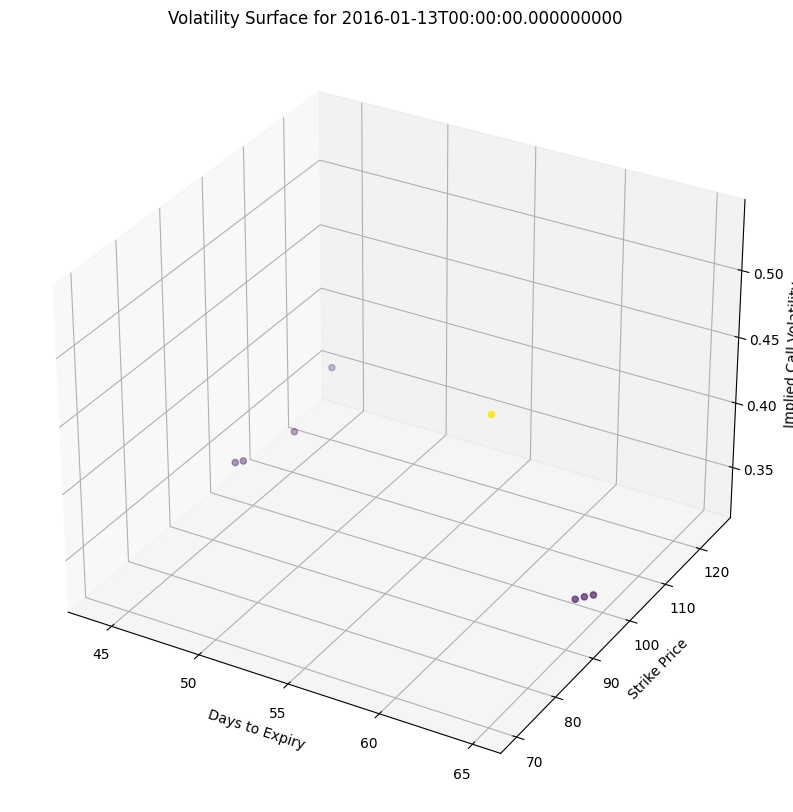

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd
import numpy as np

# Assuming 'df' is pre-defined with columns 'QUOTE_DATE', 'C_IV', 'STRIKE', 'DTE'

# Make a copy of the DataFrame to ensure original data is not modified
copy_df = df.copy()

# Setup figure and 3D axis for the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set labels for axes
ax.set_xlabel('Days to Expiry')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Implied Call Volatility')

# Prepare for animation by sorting unique dates
unique_dates = sorted(copy_df['QUOTE_DATE'].unique())

# Initialization function for the animation
def init():
    ax.set_xlabel('Days to Expiry')
    ax.set_ylabel('Strike Price')
    ax.set_zlabel('Implied Call Volatility')
    return fig,

# Function to update the plot for each frame
def update(frame):
    ax.clear()  # Clear current data
    # Set labels again because clear() removes them
    ax.set_xlabel('Days to Expiry')
    ax.set_ylabel('Strike Price')
    ax.set_zlabel('Implied Call Volatility')
    date = unique_dates[frame]
    daily_data = copy_df[copy_df['QUOTE_DATE'] == date]
    DTE = daily_data['DTE'].values
    Strike = daily_data['STRIKE'].values
    IV = daily_data['C_IV'].values
    ax.scatter(DTE, Strike, IV, c=IV, cmap='viridis')  # Color mapped by IV
    ax.set_title(f'Volatility Surface for {date}')
    return fig,

# Create animation
ani = FuncAnimation(fig, update, frames=len(unique_dates), init_func=init, blit=False, interval=200)

# Save the animation as a GIF
ani.save('volatility_surface_animation.gif', writer=PillowWriter(fps=2))

# If you want to display the animation in a Jupyter notebook, you can uncomment:
# from IPython.display import HTML
# HTML(ani.to_html5_video())


# Deduce the risk free rate [slow to run]

In [ ]:
opml_instance = OPML(df)
df=opml_instance.deduce_r_fallback_multithreaded(initial_guess=0.01)

# Create a tensor

In [ ]:
opml_instance = Core(df)
tensor = opml_instance.df_to_tensor_x(index_col='QUOTE_DATE', sort_cols=['QUOTE_DATE', 'STRIKE'])
print(tensor.shape)  # Prints the shape of the tensor


In [ ]:
plt.figure(figsize=(10,8))
df['C_VOLUME']=df['C_VOLUME'].astype('float')
df['P_VOLUME']=df['P_VOLUME'].astype('float')

df[df['QUOTE_DATE']=="2020-01-31"]['P_VOLUME'].hist(bins=40)

In [ ]:
tensor[0,0:2,:]

In [ ]:
df.sort_values(by=['QUOTE_DATE', 'STRIKE']).iloc[0,:]

In [ ]:
df.isna().sum()

# Finite Difference

In [ ]:
x = df[df['DTE'] != 0].copy().iloc[:5000,:]

pricer = FiniteDifference.FiniteDifference(x)
pricer.price_options(N=50, M=50, american=True, option_type='call')  # Set american=False for European options


In [ ]:
df.STRIKE_DISTANCE.head()

In [ ]:
x.groupby(['QUOTE_DATE'])['BS_CALL_PRICE', 'C_ASK', 'Option_Price_FD'].median().plot()